<a href="https://colab.research.google.com/github/SoulSync-Tm/D14_MFC4_Soul_Sync_Music_Seperation/blob/main/Music_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!nvidia-smi

Tue Jan 27 13:31:44 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [12]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import os
import glob
import pandas as pd
import json
import numpy as np
import librosa, librosa.display
from tqdm import tqdm
import sys

In [26]:
try:
    import openl3
    import soundfile as sf
    OPENL3_OK = True
    print("✓ OpenL3 available for embeddings")
except ImportError:
    OPENL3_OK = False
    print("⚠ OpenL3 not available - embeddings skipped")

⚠ OpenL3 not available - embeddings skipped


In [27]:
RUSSELL_EMOTIONS = {
    "happy": (0.85, 0.75),
    "excited": (0.75, 0.90),
    "euphoric": (0.90, 0.90),

    "relaxed": (0.75, 0.25),
    "calm": (0.60, 0.20),
    "content": (0.70, 0.40),

    "sad": (0.20, 0.30),
    "melancholic": (0.25, 0.35),
    "depressed": (0.10, 0.15),

    "angry": (0.15, 0.85),
    "tense": (0.30, 0.75),
    "fearful": (0.20, 0.80),

    "neutral": (0.50, 0.50)
}

In [28]:
def compute_arousal(rms, tempo, perc_energy):
    """
    Robust arousal estimation ∈ [0,1]
    Mix/mastering invariant
    """
    rms_norm = np.percentile(rms, 75) / (np.max(rms) + 1e-9)
    tempo_norm = np.clip(tempo / 180.0, 0, 1)
    perc_norm = perc_energy / (np.max(rms) + 1e-9)

    arousal = (
        0.45 * rms_norm +
        0.35 * tempo_norm +
        0.20 * perc_norm
    )
    return float(np.clip(arousal, 0, 1))

In [39]:
def detect_emotions(valence, arousal, top_k=5):
    """
    Multi-emotion soft assignment using Russell's Circumplex
    """
    scores = {}

    for emotion, (v_e, a_e) in RUSSELL_EMOTIONS.items():
        dist = np.sqrt((valence - v_e) ** 2 + (arousal - a_e) ** 2)
        scores[emotion] = np.exp(-4.0 * dist)

    total = sum(scores.values()) + 1e-9
    scores = {k: v / total for k, v in scores.items()}

    scores = dict(
        sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
    )
    print(scores)
    return scores

In [30]:
def extract_features_for_song(audio_path, sr=22050):
    try:
        print(f"Processing: {os.path.basename(audio_path)}")

        y, sr = librosa.load(audio_path, sr=sr, mono=True)
        duration = librosa.get_duration(y=y, sr=sr)

        if duration < 5.0:
            print("⚠ Skipped (too short)")
            return None

        hop_length = 512

        # === Harmonic / Percussive ===
        y_harm, y_perc = librosa.effects.hpss(y)

        onset_env = librosa.onset.onset_strength(y=y_perc, sr=sr)
        tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)

        beat_strength = np.mean(onset_env) / (np.max(onset_env) + 1e-8)

        if tempo <= 0:
            tempo_suitability = 0.0
        elif tempo < 100:
            tempo_suitability = tempo / 100.0
        elif tempo > 130:
            tempo_suitability = 130.0 / tempo
        else:
            tempo_suitability = 1.0

        rhythm_stability = 1.0
        rms = librosa.feature.rms(y=y, hop_length=hop_length)[0]
        energy_pulse = np.mean(librosa.feature.rms(y=y_perc)[0])

        danceability = float(np.clip(
            0.35 * beat_strength +
            0.25 * tempo_suitability +
            0.20 * rhythm_stability +
            0.20 * np.clip(energy_pulse * 4, 0, 1),
            0, 1
        ))

        # === Spectral ===
        centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
        flatness = librosa.feature.spectral_flatness(y=y)[0]

        # === Harmonic Ratio (FIXED) ===
        harmonic_energy = np.mean(librosa.feature.rms(y=y_harm))
        total_energy = np.mean(librosa.feature.rms(y=y))
        harmonic_ratio = harmonic_energy / (total_energy + 1e-12)

        # === Chroma / MFCC ===
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)

        S = librosa.feature.melspectrogram(y=y, sr=sr)
        mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=13)

        # === Valence Proxy ===
        centroid_norm = np.mean(centroid) / (sr / 2)
        root = chroma_mean.argmax()

        major = [(root + i) % 12 for i in [0, 4, 7]]
        minor = [(root + i) % 12 for i in [0, 3, 7]]

        major_energy = chroma_mean[major].sum()
        minor_energy = chroma_mean[minor].sum()

        triad_score = (major_energy - minor_energy) / (major_energy + minor_energy + 1e-12)
        valence = float(np.clip(
            0.6 * centroid_norm + 0.4 * (triad_score + 1) / 2,
            0, 1
        ))

        # === Arousal & Emotions ===
        arousal = compute_arousal(rms, tempo, energy_pulse)
        emotion_profile = detect_emotions(valence, arousal)

        # === OpenL3 ===
        embedding = None
        if OPENL3_OK:
            audio_sf, sr_sf = sf.read(audio_path)
            if audio_sf.ndim > 1:
                audio_sf = audio_sf.mean(axis=1)
            emb, _ = openl3.get_audio_embedding(
                audio_sf, sr_sf,
                input_repr="mel256",
                content_type="music",
                embedding_size=512
            )
            embedding = emb.mean(axis=0).tolist()

        # === Compile ===
        return {
            "file": os.path.basename(audio_path),
            "duration": float(duration),
            "tempo": float(tempo),
            "danceability": danceability,
            "valence": valence,
            "arousal": arousal,
            "dominant_emotion": max(emotion_profile, key=emotion_profile.get),
            "emotion_profile": json.dumps(emotion_profile),

            "rms_mean": float(np.mean(rms)),
            "rms_std": float(np.std(rms)),
            "centroid_mean": float(np.mean(centroid)),
            "bandwidth_mean": float(np.mean(bandwidth)),
            "rolloff_mean": float(np.mean(rolloff)),
            "flatness_mean": float(np.mean(flatness)),
            "harmonic_ratio": float(harmonic_ratio),

            "chroma_mean": chroma_mean.tolist(),
            "mfcc_mean": np.mean(mfcc, axis=1).tolist(),

            "openl3_embedding": embedding
        }

    except Exception as e:
        print(f"❌ Error: {e}")
        return None

In [31]:
def main():
    music_dir = "/content/drive/MyDrive/colab_projects/Music/music"
    csv_path = "/content/drive/MyDrive/colab_projects/Music/output/features1.csv"
    json_path = "/content/drive/MyDrive/colab_projects/Music/output/features1.json"

    audio_files = []
    for ext in ["*.mp3", "*.wav", "*.flac", "*.m4a", "*.aac"]:
        audio_files.extend(glob.glob(os.path.join(music_dir, ext)))

    print(f"📁 Found {len(audio_files)} files")

    all_features = []
    if os.path.exists(csv_path):
        all_features = pd.read_csv(csv_path).to_dict("records")

    processed = {f["file"] for f in all_features}
    new_files = [f for f in audio_files if os.path.basename(f) not in processed]

    for file in tqdm(new_files, desc="Extracting"):
        feat = extract_features_for_song(file)
        if feat:
            all_features.append(feat)

    if all_features:
        df = pd.DataFrame(all_features)
        df.to_csv(csv_path, index=False)
        with open(json_path, "w") as f:
            json.dump(all_features, f, indent=2)

        print("✅ Extraction complete")
        print(df[["file", "dominant_emotion", "valence", "arousal"]].head())

if __name__ == "__main__":
    main()


📁 Found 42 files


Extracting:   0%|          | 0/42 [00:00<?, ?it/s]

Processing: Kannumuzhi.mp3


/tmp/ipython-input-511337122.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(np.clip(arousal, 0, 1))
/tmp/ipython-input-1209817014.py:99: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "tempo": float(tempo),
Extracting:   2%|▏         | 1/42 [00:16<11:20, 16.59s/it]

Processing: Adi Alaye.mp3


/tmp/ipython-input-1209817014.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  danceability = float(np.clip(
Extracting:   5%|▍         | 2/42 [00:35<12:04, 18.11s/it]

Processing: Eppadi-Vandhaayo-MassTamilan.dev.mp3


Extracting:   7%|▋         | 3/42 [00:47<09:49, 15.12s/it]

Processing: Dandanakka-Life'u-MassTamilan.dev.mp3


Extracting:  10%|▉         | 4/42 [01:02<09:29, 14.99s/it]

Processing: Jodi Porutham.mp3


Extracting:  12%|█▏        | 5/42 [01:18<09:32, 15.46s/it]

Processing: Theekkoluthi.mp3


Extracting:  14%|█▍        | 6/42 [01:45<11:37, 19.39s/it]

Processing: Thennaadu.mp3


Extracting:  17%|█▋        | 7/42 [02:07<11:44, 20.12s/it]

Processing: Oorum Blood.mp3


Extracting:  19%|█▉        | 8/42 [02:24<10:59, 19.41s/it]

Processing: Singari.mp3


Extracting:  21%|██▏       | 9/42 [02:39<09:55, 18.05s/it]

Processing: Yumabaibesa.mp3


Extracting:  24%|██▍       | 10/42 [02:50<08:27, 15.86s/it]

Processing: Blud Is On His Way.mp3


Extracting:  26%|██▌       | 11/42 [02:55<06:27, 12.51s/it]

Processing: Nallaru Po.mp3


Extracting:  29%|██▊       | 12/42 [03:12<06:52, 13.76s/it]

Processing: Arasan-Theme-MassTamilan.dev.mp3


Extracting:  31%|███       | 13/42 [03:19<05:39, 11.71s/it]

Processing: Aaruyire.mp3


Extracting:  33%|███▎      | 14/42 [03:23<04:20,  9.31s/it]

Processing: Kannukulla.mp3


Extracting:  36%|███▌      | 15/42 [03:43<05:39, 12.56s/it]

Processing: God-Mode-MassTamilan.dev.mp3


Extracting:  38%|███▊      | 16/42 [04:00<06:04, 14.03s/it]

Processing: Beer Song.mp3


Extracting:  40%|████      | 17/42 [04:14<05:50, 14.00s/it]

Processing: Dillubaru Aaja.mp3


Extracting:  43%|████▎     | 18/42 [04:34<06:17, 15.73s/it]

Processing: Jill-Jill-MassTamilan.dev.mp3


Extracting:  45%|████▌     | 19/42 [04:50<06:04, 15.85s/it]

Processing: Back From The Dead.mp3


Extracting:  48%|████▊     | 20/42 [04:54<04:30, 12.28s/it]

Processing: Maarudho-MassTamilan.dev.mp3


Extracting:  50%|█████     | 21/42 [05:14<05:06, 14.60s/it]

Processing: Thirudi.mp3


Extracting:  52%|█████▏    | 22/42 [05:31<05:04, 15.23s/it]

Processing: Dayal.mp3


Extracting:  55%|█████▍    | 23/42 [05:39<04:07, 13.02s/it]

Processing: Rajasekar's Lab.mp3


Extracting:  57%|█████▋    | 24/42 [05:47<03:29, 11.65s/it]

Processing: Animal Instinct.mp3


Extracting:  60%|█████▉    | 25/42 [05:50<02:35,  9.16s/it]

Processing: Madharaasi Flow.mp3


Extracting:  62%|██████▏   | 26/42 [05:54<01:59,  7.46s/it]

Processing: Dahaa Theme.mp3


Extracting:  64%|██████▍   | 27/42 [06:08<02:21,  9.46s/it]

Processing: Madharaasi Theme.mp3


Extracting:  67%|██████▋   | 28/42 [06:14<01:57,  8.37s/it]

Processing: Mudinja Thodra.mp3


Extracting:  69%|██████▉   | 29/42 [06:24<01:56,  8.97s/it]

Processing: Salambala.mp3


Extracting:  71%|███████▏  | 30/42 [06:41<02:17, 11.45s/it]

Processing: Thangapoovey.mp3


Extracting:  74%|███████▍  | 31/42 [06:59<02:27, 13.40s/it]

Processing: Usara Uruvi.mp3


Extracting:  76%|███████▌  | 32/42 [07:15<02:20, 14.02s/it]

Processing: Unadhu Enadhu.mp3


Extracting:  79%|███████▊  | 33/42 [07:35<02:22, 15.85s/it]

Processing: Give me Some Bun Butter Jam.mp3


Extracting:  81%|████████  | 34/42 [07:38<01:36, 12.06s/it]

Processing: Vazhiyiraen.mp3


Extracting:  83%|████████▎ | 35/42 [07:56<01:37, 13.87s/it]

Processing: Edho Pesathaane.mp3


Extracting:  86%|████████▌ | 36/42 [08:12<01:25, 14.28s/it]

Processing: Oli Thedi.mp3


Extracting:  88%|████████▊ | 37/42 [08:24<01:09, 13.86s/it]

Processing: Diya Diya.mp3


Extracting:  90%|█████████ | 38/42 [08:46<01:04, 16.11s/it]

Processing: Kaajuma.mp3


Extracting:  93%|█████████▎| 39/42 [09:07<00:52, 17.60s/it]

Processing: Vaanavilley.mp3


Extracting:  95%|█████████▌| 40/42 [09:27<00:36, 18.39s/it]

Processing: Validhaano Kaadhal.mp3


Extracting:  98%|█████████▊| 41/42 [09:48<00:19, 19.19s/it]

Processing: Vizhi Veekura.mp3


Extracting: 100%|██████████| 42/42 [10:05<00:00, 14.41s/it]

✅ Extraction complete
                                    file dominant_emotion   valence   arousal
0                         Kannumuzhi.mp3      melancholic  0.307999  0.521693
1                          Adi Alaye.mp3      melancholic  0.298056  0.528846
2   Eppadi-Vandhaayo-MassTamilan.dev.mp3      melancholic  0.308555  0.456728
3  Dandanakka-Life'u-MassTamilan.dev.mp3            tense  0.305637  0.553596
4                      Jodi Porutham.mp3      melancholic  0.316681  0.484409


In [40]:
import numpy as np
import matplotlib.pyplot as plt

def plot_emotion_cloud(emotion_profile, sigma=0.08, resolution=300):
    """
    Visualize Russell circumplex emotion cloud
    """
    # Create grid
    x = np.linspace(0, 1, resolution)
    y = np.linspace(0, 1, resolution)
    X, Y = np.meshgrid(x, y)

    Z = np.zeros_like(X)

    # Accumulate emotion Gaussians
    for emotion, weight in emotion_profile.items():
        if emotion not in RUSSELL_EMOTIONS:
            continue

        v_e, a_e = RUSSELL_EMOTIONS[emotion]

        Z += weight * np.exp(
            -((X - v_e)**2 + (Y - a_e)**2) / (2 * sigma**2)
        )

    # Normalize
    Z /= (Z.max() + 1e-9)

    # Plot
    plt.figure(figsize=(7, 7))
    plt.imshow(
        Z,
        origin="lower",
        extent=[0, 1, 0, 1],
        cmap="plasma",
        alpha=0.9
    )

    plt.colorbar(label="Emotion Density")

    # Plot emotion anchors
    for emotion, (v, a) in RUSSELL_EMOTIONS.items():
        plt.scatter(v, a, color="white", s=12, alpha=0.5)
        plt.text(v + 0.01, a + 0.01, emotion, fontsize=8, color="white")

    plt.xlabel("Valence →")
    plt.ylabel("Arousal →")
    plt.title("Emotion Cloud (Russell Circumplex)")
    plt.tight_layout()
    plt.show()


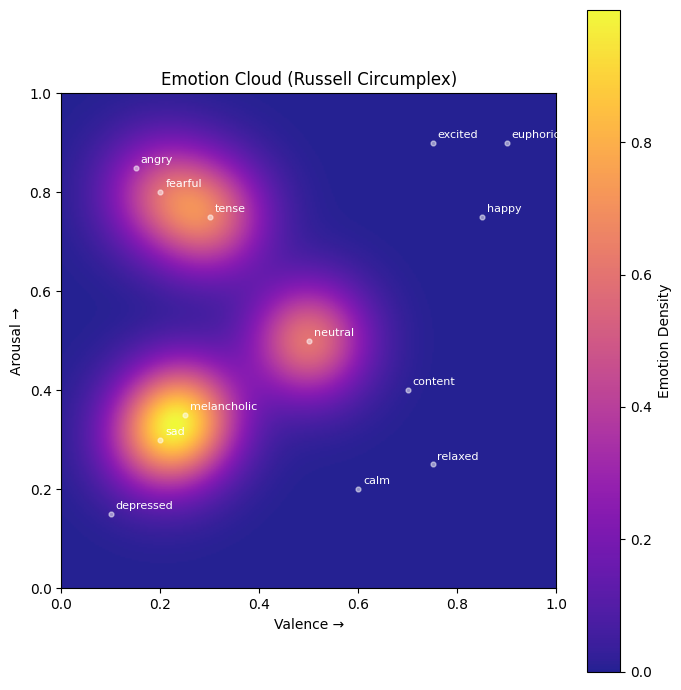

In [38]:
import json
import pandas as pd # Import pandas

# Define the path to the CSV file generated by the main function
csv_path = "/content/drive/MyDrive/colab_projects/Music/output/features1.csv"

# Load the DataFrame
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    if not df.empty:
        # Select the first row to plot its emotion profile
        row = df.iloc[0]
        emotion_profile = json.loads(row["emotion_profile"])
        plot_emotion_cloud(emotion_profile)
    else:
        print(f"❌ The CSV file at {csv_path} is empty.")
else:
    print(f"❌ CSV file not found at {csv_path}. Please run the main extraction function first.")
